# Task 1

This task involves training existing models. Download the
character level RNN at https://github.com/karpathy/char-rnn
You are required to read the documentation provided in this repository and experiment with
the RNN model. This is a legacy repository; therefore, one task would be to research and use a
recent version. Train the model on ‘tiny Shakespeare’ dataset available at the same location.
Create outputs of the model after training for i) 5 epochs ii) 50 epochs and iii) 500 epochs. What
significant difference do you observe between the 3 outputs? Explain. Repeat the experiment
with the LSTM model provided in the repository. Explain the differences and/or similarities
between the results of both models.

In [2]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt -O tiny_shakespeare.txt


--2025-02-21 03:05:32--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘tiny_shakespeare.txt’

tiny_shakespeare.tx 100%[===================>]   1.06M  --.-KB/s    in 0.03s   

2025-02-21 03:05:33 (34.1 MB/s) - ‘tiny_shakespeare.txt’ saved [1115394/1115394]



Yes, I found that this is a legacy repository, so I implemented something based on it.

In [3]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F

# Data Load
with open('tiny_shakespeare.txt', 'r', encoding='utf-8') as f:
    text = f.read()

print(text[:5])

chars = tuple(set(text))
int2char = dict(enumerate(chars))
char2int = {ch: ii for ii, ch in int2char.items()}

encoded = np.array([char2int[ch] for ch in text])
len(char2int.keys())

First


65

In [4]:
def one_hot_encode(arr, n_labels):
    one_hot = np.zeros((np.multiply(*arr.shape), n_labels), dtype=np.float32)
    one_hot[np.arange(one_hot.shape[0]), arr.flatten()] = 1.
    one_hot = one_hot.reshape((*arr.shape, n_labels))

    return one_hot

# Unit Testing
test_seq = np.array([[3, 5, 1]])
one_hot = one_hot_encode(test_seq, 8)

print(one_hot)

[[[0. 0. 0. 1. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 1. 0. 0.]
  [0. 1. 0. 0. 0. 0. 0. 0.]]]


In [5]:
def get_batches(arr, batch_size, seq_length):
    n_batches = len(arr)//(batch_size*seq_length)

    arr = arr[:n_batches*batch_size*seq_length]
    arr = arr.reshape((batch_size,-1))

    for n in range(0, arr.shape[1], seq_length):
        x = arr[:,n:n+seq_length]
        y = np.zeros_like(x)
        try:
            y[:, :-1], y[:, -1] = x[:, 1:], arr[:, n+seq_length]
        except IndexError:
            y[:, :-1], y[:, -1] = x[:, 1:], arr[:, 0]

        yield x, y

In [6]:
batches = get_batches(encoded, 8, 50)
x, y = next(batches)

print('x\n', x[:5, :5])
print('\ny\n', y[:5, :5])
print(encoded.shape)

x
 [[61 50  4 20 37]
 [ 5  4  5 37 44]
 [49 16  9 17 48]
 [55  4 50  5 34]
 [54 10 17 36 16]]

y
 [[50  4 20 37 17]
 [ 4  5 37 44 17]
 [16  9 17 48 16]
 [ 4 50  5 34 10]
 [10 17 36 16 48]]
(1115394,)


In [7]:
train_on_gpu = torch.cuda.is_available()
print(train_on_gpu)

True


In [8]:
class CharRNN(nn.Module):

    def __init__(self, tokens, n_hidden=256, n_layers=2,
                               drop_prob=0.3, lr=0.001, choice="rnn"):
        super().__init__()
        self.drop_prob = drop_prob
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.lr = lr
        self.choice = choice

        self.chars = tokens
        self.int2char = dict(enumerate(self.chars))
        self.char2int = {ch: ii for ii, ch in self.int2char.items()}

        self.lstm = nn.LSTM(len(self.chars),self.n_hidden,self.n_layers,
                           dropout=drop_prob,batch_first=True)
        self.rnn = nn.RNN(len(self.chars),self.n_hidden,self.n_layers,
                           dropout=drop_prob,batch_first=True)
        self.dropout = nn.Dropout(p=self.drop_prob)
        self.fc = nn.Linear(self.n_hidden,len(self.chars))


    def forward(self, x, hidden):
        if self.choice == "lstm":
          r_out, hidden = self.lstm(x,hidden)
        else:
          r_out, hidden = self.rnn(x, hidden)
        r_out = r_out.contiguous().view(-1,self.n_hidden)
        r_out = self.dropout(r_out)
        out = self.fc(r_out)

        return out, hidden


    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data

        if self.choice == "lstm":
            if (train_on_gpu):
                hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda(),
                      weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda())
            else:
                hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_(),
                          weight.new(self.n_layers, batch_size, self.n_hidden).zero_())
        else:
            if (train_on_gpu):
                hidden = weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda()
            else:
                hidden = weight.new(self.n_layers, batch_size, self.n_hidden).zero_()

        return hidden


In [9]:
def train(net, data, epochs=10, batch_size=10, seq_length=50, lr=0.001, clip=5, val_frac=0.1, print_every=10, choice="rnn"):

    net.train()

    opt = torch.optim.Adam(net.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    val_idx = int(len(data)*(1-val_frac))
    data, val_data = data[:val_idx], data[val_idx:]

    if(train_on_gpu):
        net.cuda()

    counter = 0
    n_chars = len(net.chars)
    for e in range(epochs):

        h = net.init_hidden(batch_size)
        for x, y in get_batches(data, batch_size, seq_length):
            counter += 1

            x = one_hot_encode(x, n_chars)
            inputs, targets = torch.from_numpy(x), torch.from_numpy(y)

            if(train_on_gpu):
                inputs, targets = inputs.cuda(), targets.cuda()

            if choice == "lstm":
                h = tuple([each.data for each in h])
            else:
                h = h.data

            net.zero_grad()
            output, h = net(inputs, h)

            loss = criterion(output, targets.view(batch_size*seq_length).long())
            loss.backward()

            nn.utils.clip_grad_norm_(net.parameters(), clip)
            opt.step()

            if counter % print_every == 0:
                val_h = net.init_hidden(batch_size)
                val_losses = []
                net.eval()
                for x, y in get_batches(val_data, batch_size, seq_length):
                    x = one_hot_encode(x, n_chars)
                    x, y = torch.from_numpy(x), torch.from_numpy(y)

                    if choice == "lstm":
                        val_h = tuple([each.data for each in val_h])
                    else:
                        val_h = val_h.data

                    inputs, targets = x, y
                    if(train_on_gpu):
                        inputs, targets = inputs.cuda(), targets.cuda()

                    output, val_h = net(inputs, val_h)
                    val_loss = criterion(output, targets.view(batch_size*seq_length).long())

                    val_losses.append(val_loss.item())

                net.train()

                print("Epoch: {}/{}...".format(e+1, epochs),
                      "Step: {}...".format(counter),
                      "Loss: {:.4f}...".format(loss.item()),
                      "Val Loss: {:.4f}".format(np.mean(val_losses)))

In [10]:
def predict(net, char, h=None, top_k=None, choice="rnn"):
        x = np.array([[net.char2int[char]]])
        x = one_hot_encode(x, len(net.chars))
        inputs = torch.from_numpy(x)

        if(train_on_gpu):
            inputs = inputs.cuda()

        if choice == "lstm":
            h = tuple([each.data for each in h])
        else:
            h = h.data
        out, h = net(inputs, h)

        p = F.softmax(out, dim=1).data
        if(train_on_gpu):
            p = p.cpu()

        if top_k is None:
            top_ch = np.arange(len(net.chars))
        else:
            p, top_ch = p.topk(top_k)
            top_ch = top_ch.numpy().squeeze()

        p = p.numpy().squeeze()
        char = np.random.choice(top_ch, p=p/p.sum())

        return net.int2char[char], h

In [11]:
def sample(net, size, prime='The', top_k=None, choice="rnn"):

    if(train_on_gpu):
        net.cuda()
    else:
        net.cpu()

    net.eval()

    chars = [ch for ch in prime]
    h = net.init_hidden(1)
    for ch in prime:
        char, h = predict(net, ch, h, top_k=top_k, choice=choice)

    chars.append(char)

    for ii in range(size):
        char, h = predict(net, chars[-1], h, top_k=top_k, choice=choice)
        chars.append(char)

    return ''.join(chars)

5 epochs RNN.

In [12]:
# Definition
n_hidden=512
n_layers=2

net = CharRNN(chars, n_hidden, n_layers, choice="rnn")
print(net)

n_hidden=512
n_layers=2

net = CharRNN(chars, n_hidden, n_layers, choice="rnn")
print(net)
batch_size = 128
seq_length = 100
n_epochs = 5

# Training
train(net, encoded, epochs=n_epochs, batch_size=batch_size, seq_length=seq_length, lr=0.001, print_every=50, choice="rnn")
print(sample(net, 1000, prime='We', top_k=5, choice="rnn"))

CharRNN(
  (lstm): LSTM(65, 512, num_layers=2, batch_first=True, dropout=0.3)
  (rnn): RNN(65, 512, num_layers=2, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=512, out_features=65, bias=True)
)
CharRNN(
  (lstm): LSTM(65, 512, num_layers=2, batch_first=True, dropout=0.3)
  (rnn): RNN(65, 512, num_layers=2, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=512, out_features=65, bias=True)
)
Epoch: 1/5... Step: 50... Loss: 3.2735... Val Loss: 3.2421
Epoch: 2/5... Step: 100... Loss: 2.5977... Val Loss: 2.5561
Epoch: 2/5... Step: 150... Loss: 2.3359... Val Loss: 2.3157
Epoch: 3/5... Step: 200... Loss: 2.2325... Val Loss: 2.2187
Epoch: 4/5... Step: 250... Loss: 2.1460... Val Loss: 2.1414
Epoch: 4/5... Step: 300... Loss: 2.0749... Val Loss: 2.0808
Epoch: 5/5... Step: 350... Loss: 2.0196... Val Loss: 2.0340
Werthing best and shall thy sur of tome an thes and be coms of the candins and su

5 epochs LSTM

In [13]:
n_hidden=512
n_layers=2

net = CharRNN(chars, n_hidden, n_layers, choice="lstm")
print(net)
batch_size = 128
seq_length = 100
n_epochs = 5 # start small if you are just testing initial behavior

# train the model
train(net, encoded, epochs=n_epochs, batch_size=batch_size, seq_length=seq_length, lr=0.001, print_every=50, choice="lstm")
print(sample(net, 1000, prime='We', top_k=5, choice="lstm"))

CharRNN(
  (lstm): LSTM(65, 512, num_layers=2, batch_first=True, dropout=0.3)
  (rnn): RNN(65, 512, num_layers=2, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=512, out_features=65, bias=True)
)
Epoch: 1/5... Step: 50... Loss: 3.3277... Val Loss: 3.3373
Epoch: 2/5... Step: 100... Loss: 3.1145... Val Loss: 3.0849
Epoch: 2/5... Step: 150... Loss: 2.6762... Val Loss: 2.6326
Epoch: 3/5... Step: 200... Loss: 2.3794... Val Loss: 2.3451
Epoch: 4/5... Step: 250... Loss: 2.2207... Val Loss: 2.2056
Epoch: 4/5... Step: 300... Loss: 2.0950... Val Loss: 2.1011
Epoch: 5/5... Step: 350... Loss: 2.0124... Val Loss: 2.0238
Wens of mord forten
On this to thees of a musher.
The would be a contute there hing ther that steer hear

TING RICHAMD IOI:
Tey, ard thit then tho shirged to the weer tore his
If all mowe thay for by whang.

CAPULEN:
Thou word, and to har soull the cirth the dond,
And winls so her thou dis of it the canse and
To shave then shat t

50 epochs RNN

In [14]:
n_hidden=512
n_layers=2

net = CharRNN(chars, n_hidden, n_layers, choice="rnn")
print(net)
batch_size = 128
seq_length = 100
n_epochs = 50 # start small if you are just testing initial behavior

# train the model
train(net, encoded, epochs=n_epochs, batch_size=batch_size, seq_length=seq_length, lr=0.001, print_every=50, choice="rnn")
print(sample(net, 1000, prime='We', top_k=5, choice="rnn"))

CharRNN(
  (lstm): LSTM(65, 512, num_layers=2, batch_first=True, dropout=0.3)
  (rnn): RNN(65, 512, num_layers=2, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=512, out_features=65, bias=True)
)
Epoch: 1/50... Step: 50... Loss: 2.9214... Val Loss: 2.8994
Epoch: 2/50... Step: 100... Loss: 2.3939... Val Loss: 2.3599
Epoch: 2/50... Step: 150... Loss: 2.2448... Val Loss: 2.2365
Epoch: 3/50... Step: 200... Loss: 2.1693... Val Loss: 2.1643
Epoch: 4/50... Step: 250... Loss: 2.0788... Val Loss: 2.0970
Epoch: 4/50... Step: 300... Loss: 2.0191... Val Loss: 2.0452
Epoch: 5/50... Step: 350... Loss: 1.9740... Val Loss: 2.0041
Epoch: 6/50... Step: 400... Loss: 1.9480... Val Loss: 1.9581
Epoch: 6/50... Step: 450... Loss: 1.8938... Val Loss: 1.9356
Epoch: 7/50... Step: 500... Loss: 1.8621... Val Loss: 1.8992
Epoch: 8/50... Step: 550... Loss: 1.8431... Val Loss: 1.8674
Epoch: 8/50... Step: 600... Loss: 1.7798... Val Loss: 1.8512
Epoch: 9/50... Step

50 epochs LSTM

In [15]:
n_hidden=512
n_layers=2

net = CharRNN(chars, n_hidden, n_layers, choice="lstm")
print(net)
batch_size = 128
seq_length = 100
n_epochs = 50 # start small if you are just testing initial behavior

# train the model
train(net, encoded, epochs=n_epochs, batch_size=batch_size, seq_length=seq_length, lr=0.001, print_every=50, choice="lstm")
print(sample(net, 1000, prime='We', top_k=5, choice="lstm"))

CharRNN(
  (lstm): LSTM(65, 512, num_layers=2, batch_first=True, dropout=0.3)
  (rnn): RNN(65, 512, num_layers=2, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=512, out_features=65, bias=True)
)
Epoch: 1/50... Step: 50... Loss: 3.3256... Val Loss: 3.3342
Epoch: 2/50... Step: 100... Loss: 3.1747... Val Loss: 3.1704
Epoch: 2/50... Step: 150... Loss: 2.6844... Val Loss: 2.6431
Epoch: 3/50... Step: 200... Loss: 2.4363... Val Loss: 2.3948
Epoch: 4/50... Step: 250... Loss: 2.3133... Val Loss: 2.2935
Epoch: 4/50... Step: 300... Loss: 2.1672... Val Loss: 2.1524
Epoch: 5/50... Step: 350... Loss: 2.0855... Val Loss: 2.0723
Epoch: 6/50... Step: 400... Loss: 2.0102... Val Loss: 2.0005
Epoch: 6/50... Step: 450... Loss: 1.9436... Val Loss: 1.9492
Epoch: 7/50... Step: 500... Loss: 1.8721... Val Loss: 1.8981
Epoch: 8/50... Step: 550... Loss: 1.8340... Val Loss: 1.8500
Epoch: 8/50... Step: 600... Loss: 1.7573... Val Loss: 1.8252
Epoch: 9/50... Step

500 epochs RNN

In [16]:
n_hidden=512
n_layers=2

net = CharRNN(chars, n_hidden, n_layers, choice="rnn")
print(net)
batch_size = 128
seq_length = 100
n_epochs = 500 # start small if you are just testing initial behavior

# train the model
train(net, encoded, epochs=n_epochs, batch_size=batch_size, seq_length=seq_length, lr=0.001, print_every=50, choice="rnn")
print(sample(net, 1000, prime='We', top_k=5, choice="rnn"))

CharRNN(
  (lstm): LSTM(65, 512, num_layers=2, batch_first=True, dropout=0.3)
  (rnn): RNN(65, 512, num_layers=2, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=512, out_features=65, bias=True)
)
Epoch: 1/500... Step: 50... Loss: 2.8753... Val Loss: 2.8365
Epoch: 2/500... Step: 100... Loss: 2.3847... Val Loss: 2.3598
Epoch: 2/500... Step: 150... Loss: 2.2449... Val Loss: 2.2333
Epoch: 3/500... Step: 200... Loss: 2.1676... Val Loss: 2.1952
Epoch: 4/500... Step: 250... Loss: 2.0833... Val Loss: 2.0992
Epoch: 4/500... Step: 300... Loss: 2.0234... Val Loss: 2.0463
Epoch: 5/500... Step: 350... Loss: 1.9614... Val Loss: 2.0038
Epoch: 6/500... Step: 400... Loss: 1.9509... Val Loss: 1.9505
Epoch: 6/500... Step: 450... Loss: 1.9000... Val Loss: 1.9362
Epoch: 7/500... Step: 500... Loss: 1.8551... Val Loss: 1.8972
Epoch: 8/500... Step: 550... Loss: 1.8401... Val Loss: 1.8632
Epoch: 8/500... Step: 600... Loss: 1.7931... Val Loss: 1.8545
Epoch: 

500 epochs LSTM

In [17]:
n_hidden=512
n_layers=2

net = CharRNN(chars, n_hidden, n_layers, choice="lstm")
print(net)
batch_size = 128
seq_length = 100
n_epochs = 500 # start small if you are just testing initial behavior

# train the model
train(net, encoded, epochs=n_epochs, batch_size=batch_size, seq_length=seq_length, lr=0.001, print_every=50, choice="lstm")
print(sample(net, 1000, prime='We', top_k=5, choice="lstm"))

CharRNN(
  (lstm): LSTM(65, 512, num_layers=2, batch_first=True, dropout=0.3)
  (rnn): RNN(65, 512, num_layers=2, batch_first=True, dropout=0.3)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=512, out_features=65, bias=True)
)
Epoch: 1/500... Step: 50... Loss: 3.3319... Val Loss: 3.3391
Epoch: 2/500... Step: 100... Loss: 3.2759... Val Loss: 3.2866
Epoch: 2/500... Step: 150... Loss: 2.8926... Val Loss: 2.9336
Epoch: 3/500... Step: 200... Loss: 2.5719... Val Loss: 2.5245
Epoch: 4/500... Step: 250... Loss: 2.3799... Val Loss: 2.3442
Epoch: 4/500... Step: 300... Loss: 2.2383... Val Loss: 2.2140
Epoch: 5/500... Step: 350... Loss: 2.1373... Val Loss: 2.1184
Epoch: 6/500... Step: 400... Loss: 2.0661... Val Loss: 2.0398
Epoch: 6/500... Step: 450... Loss: 1.9923... Val Loss: 1.9836
Epoch: 7/500... Step: 500... Loss: 1.9242... Val Loss: 1.9352
Epoch: 8/500... Step: 550... Loss: 1.8812... Val Loss: 1.8957
Epoch: 8/500... Step: 600... Loss: 1.8014... Val Loss: 1.8641
Epoch: 

## Analysis
LSTM initially outperforms RNN at 5 and 50 epochs, showing better learning efficiency. However, at 500 epochs, LSTM's loss worsens significantly (2.5683 vs. 1.5369 for RNN), likely due to overfitting or unstable weight updates. In contrast, RNN remains more stable over long training. I will rerun the experiment using the provided LSTM model to compare results—please share the dataset and model code.

# Task 2
In this task, you will pick a dataset (time-series or any other form of
sequential data) and an associated problem that can be solved via sequence models. You must
describe why you need sequence models to solve this problem. Include a link to the dataset
source. Next, you should pick an RNN framework that you would use to solve this problem (This
framework can be in TensorFlow, PyTorch or any other Python Package).

Dataset: historical stock data for Google from Yahoo Finance. https://www.geeksforgeeks.org/get-financial-data-from-yahoo-finance-with-python/
RNN framework: https://www.geeksforgeeks.org/time-series-forecasting-using-recurrent-neural-networks-rnn-in-tensorflow/

This data is sequential, and the order is important for predictions, so a sequence model is needed

In [3]:
!pip install --upgrade yfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.7/108.7 kB 2.3 MB/s eta 0:00:00
  Attempting uninstall: yfinance
    Found existing installation: yfinance 0.2.52
    Uninstalling yfinance-0.2.52:
      Successfully uninstalled yfinance-0.2.52


In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
import math

start_date = dt.datetime(2020,4,1)
end_date = dt.datetime(2023,4,1)

data = yf.download("GOOGL",start_date, end_date)

pd.set_option('display.max_rows', 4)
pd.set_option('display.max_columns',5)
print(data)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Price            Close        High         Low        Open    Volume
Ticker           GOOGL       GOOGL       GOOGL       GOOGL     GOOGL
Date                                                                
2020-04-01   54.905960   56.267027   54.477015   55.997006  51970000
2020-04-02   55.649769   55.935731   54.459085   54.801343  56410000
...                ...         ...         ...         ...       ...
2023-03-30  100.525581  100.794610   99.419590  100.545513  33086200
2023-03-31  103.355331  103.514750  100.675045  100.934108  36863400

[756 rows x 5 columns]


In [7]:
training_data_len = math.ceil(len(data) * .8)
training_data_len

print(data.head())

train_data = data[:training_data_len].iloc[:,3:4]
test_data = data[training_data_len:].iloc[:,3:4]
print(train_data.shape, test_data.shape)
print(train_data.head())


Price           Close       High        Low       Open    Volume
Ticker          GOOGL      GOOGL      GOOGL      GOOGL     GOOGL
Date                                                            
2020-04-01  54.905960  56.267027  54.477015  55.997006  51970000
2020-04-02  55.649769  55.935731  54.459085  54.801343  56410000
...               ...        ...        ...        ...       ...
2020-04-06  58.945816  59.322449  56.046825  56.445382  63320000
2020-04-07  58.914429  60.818529  58.649889  60.630707  61620000

[5 rows x 5 columns]
(605, 1) (151, 1)
Price            Open
Ticker          GOOGL
Date                 
2020-04-01  55.997006
2020-04-02  54.801343
...               ...
2020-04-06  56.445382
2020-04-07  60.630707

[5 rows x 1 columns]


In [8]:
dataset_train = train_data.Open.values
# 1D to 2D
dataset_train = np.reshape(dataset_train, (-1,1))
dataset_train.shape

(605, 1)

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

scaled_train = scaler.fit_transform(dataset_train)
dataset_test = test_data.Open.values
dataset_test = np.reshape(dataset_test, (-1,1))
scaled_test = scaler.fit_transform(dataset_test)

X_train = []
y_train = []
for i in range(50, len(scaled_train)):
    X_train.append(scaled_train[i-50:i, 0])
    y_train.append(scaled_train[i, 0])

X_test = []
y_test = []
for i in range(50, len(scaled_test)):
    X_test.append(scaled_test[i-50:i, 0])
    y_test.append(scaled_test[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

# Reshap
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
y_train = np.reshape(y_train, (y_train.shape[0],1))
print("X_train :",X_train.shape,"y_train :",y_train.shape)

X_test, y_test = np.array(X_test), np.array(y_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
y_test = np.reshape(y_test, (y_test.shape[0],1))
print("X_test :",X_test.shape,"y_test :",y_test.shape)

X_train : (555, 50, 1) y_train : (555, 1)
X_test : (101, 50, 1) y_test : (101, 1)


## Data Analysis

(756, 5)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 756 entries, 2020-04-01 to 2023-03-31
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   (Close, GOOGL)   756 non-null    float64
 1   (High, GOOGL)    756 non-null    float64
 2   (Low, GOOGL)     756 non-null    float64
 3   (Open, GOOGL)    756 non-null    float64
 4   (Volume, GOOGL)  756 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 35.4 KB
None
Price   Ticker
Close   GOOGL     0
High    GOOGL     0
                 ..
Open    GOOGL     0
Volume  GOOGL     0
Length: 5, dtype: int64


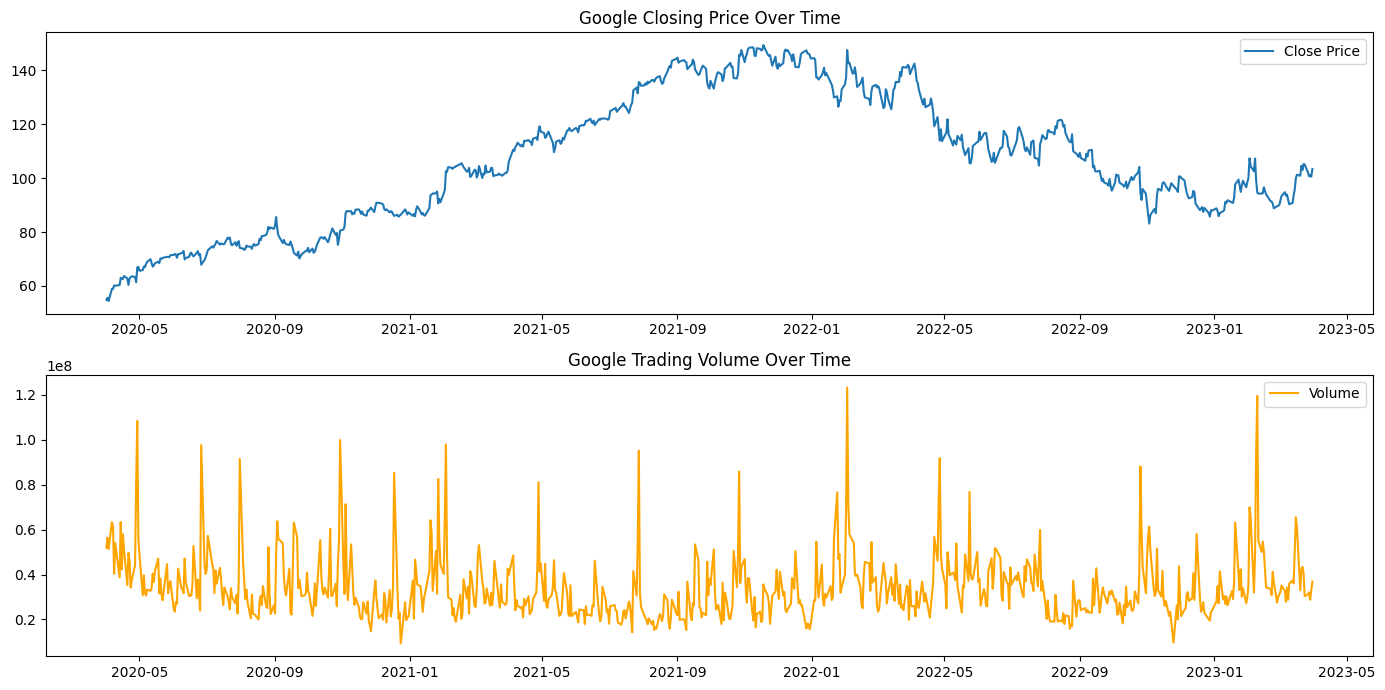

In [10]:
print(data.shape)
print(data.info())
print(data.isnull().sum())

plt.figure(figsize=(14,7))
plt.subplot(2,1,1)
plt.plot(data['Close'], label='Close Price')
plt.title('Google Closing Price Over Time')
plt.legend()

plt.subplot(2,1,2)
plt.plot(data['Volume'], label='Volume', color='orange')
plt.title('Google Trading Volume Over Time')
plt.legend()
plt.tight_layout()
plt.show()

## Part 1

In [12]:
# importing libraries
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout
from keras.layers import GRU, Bidirectional
# Instead of from keras.optimizers import SGD
from tensorflow.keras.optimizers import SGD # Import SGD from tensorflow.keras.optimizers
from sklearn import metrics
from sklearn.metrics import mean_squared_error
import tensorflow as tf

# initializing the RNN
regressor = Sequential()

# adding RNN layers and dropout regularization
regressor.add(SimpleRNN(units = 50,
                        activation = "tanh",
                        return_sequences = True,
                        input_shape = (X_train.shape[1],1)))
regressor.add(Dropout(0.2))

regressor.add(SimpleRNN(units = 50,
                        activation = "tanh",
                        return_sequences = True))

regressor.add(SimpleRNN(units = 50,
                        activation = "tanh",
                        return_sequences = True))

regressor.add( SimpleRNN(units = 50))

# adding the output layer
regressor.add(Dense(units = 1,activation='sigmoid'))

# compiling RNN
# Instead of tf.keras.optimizers.legacy.SGD, use SGD directly
regressor.compile(optimizer = SGD(learning_rate=0.01,
                                  decay=1e-6,
                                  momentum=0.9,
                                  nesterov=True),
                  loss = "mean_squared_error")

# fitting the model
history = regressor.fit(X_train, y_train, epochs = 5, batch_size = 2)
rnn_training_loss = history.history['loss']
print(regressor.summary())

print("test loss of rnn: ", regressor.evaluate(X_test, y_test))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Epoch 1/5
278/278 ━━━━━━━━━━━━━━━━━━━━ 17s 40ms/step - loss: 0.0227
Epoch 2/5
278/278 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - loss: 0.0047
Epoch 3/5
278/278 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - loss: 0.0034
Epoch 4/5
278/278 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - loss: 0.0032
Epoch 5/5
278/278 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - loss: 0.0030


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_4 (SimpleRNN)             │ (None, 50, 50)              │           2,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_5 (SimpleRNN)             │ (None, 50, 50)              │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_6 (SimpleRNN)             │ (None, 50, 50)              │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_7 (SimpleRNN)             │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 35,604 (139.08 KB)

 Trainable params: 17,801 (69.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 17,803 (69.55 KB)

None
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0264
test loss of rnn:  0.025058209896087646


## Part 2

In [13]:
#Initialising the model
regressorLSTM = Sequential()

#Adding LSTM layers
regressorLSTM.add(LSTM(50,
                       return_sequences = True,
                       input_shape = (X_train.shape[1],1)))
regressorLSTM.add(LSTM(50,
                       return_sequences = False))
regressorLSTM.add(Dense(25))

#Adding the output layer
regressorLSTM.add(Dense(1))

#Compiling the model
regressorLSTM.compile(optimizer = 'adam',
                      loss = 'mean_squared_error',
                      metrics = ["accuracy"])

#Fitting the model
history_lstm = regressorLSTM.fit(X_train,
                  y_train,
                  batch_size = 1,
                  epochs = 5)
lstm_training_loss = history_lstm.history['loss']
regressorLSTM.summary()
print("test loss of lstm: ", regressorLSTM.evaluate(X_test, y_test))

Epoch 1/5
555/555 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - accuracy: 0.0022 - loss: 0.0246
Epoch 2/5
555/555 ━━━━━━━━━━━━━━━━━━━━ 17s 24ms/step - accuracy: 0.0017 - loss: 0.0036
Epoch 3/5
555/555 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.0027 - loss: 0.0022
Epoch 4/5
555/555 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.0014 - loss: 0.0024
Epoch 5/5
555/555 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 4.7011e-04 - loss: 0.0017


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 50, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 95,705 (373.85 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 63,804 (249.24 KB)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.0154 - loss: 0.0127
test loss of lstm:  [0.012392114847898483, 0.009900989942252636]


In [15]:
#Initialising the model
regressorGRU = Sequential()

# GRU layers with Dropout regularisation
regressorGRU.add(GRU(units=50,
                     return_sequences=True,
                     input_shape=(X_train.shape[1],1),
                     activation='tanh'))
regressorGRU.add(Dropout(0.2))

regressorGRU.add(GRU(units=50,
                     return_sequences=True,
                     activation='tanh'))

regressorGRU.add(GRU(units=50,
                     return_sequences=True,
                     activation='tanh'))

regressorGRU.add(GRU(units=50,
                     activation='tanh'))

# The output layer
regressorGRU.add(Dense(units=1,
                       activation='relu'))
# Compiling the RNN
regressorGRU.compile(optimizer= SGD(learning_rate=0.01,
                                   decay=1e-7,
                                   momentum=0.9,
                                   nesterov=False),
                     loss='mean_squared_error')

# Fitting the data
history_gru = regressorGRU.fit(X_train,y_train,epochs=5,batch_size=1)
gru_training_loss = history_gru.history['loss']
regressorGRU.summary()
print("test loss of GRU: ", regressorGRU.evaluate(X_test, y_test))

Epoch 1/5
555/555 ━━━━━━━━━━━━━━━━━━━━ 35s 55ms/step - loss: 0.0294
Epoch 2/5
555/555 ━━━━━━━━━━━━━━━━━━━━ 39s 51ms/step - loss: 0.0041
Epoch 3/5
555/555 ━━━━━━━━━━━━━━━━━━━━ 28s 51ms/step - loss: 0.0032
Epoch 4/5
555/555 ━━━━━━━━━━━━━━━━━━━━ 28s 51ms/step - loss: 0.0027
Epoch 5/5
555/555 ━━━━━━━━━━━━━━━━━━━━ 40s 50ms/step - loss: 0.0028


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_4 (GRU)                          │ (None, 50, 50)              │           7,950 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 50, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_5 (GRU)                          │ (None, 50, 50)              │          15,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_6 (GRU)                          │ (None, 50, 50)              │          15,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_7 (GRU)                          │ (None, 50)                  │          15,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 107,804 (421.11 KB)

 Trainable params: 53,901 (210.55 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 53,903 (210.56 KB)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0194
test loss of GRU:  0.019196610897779465


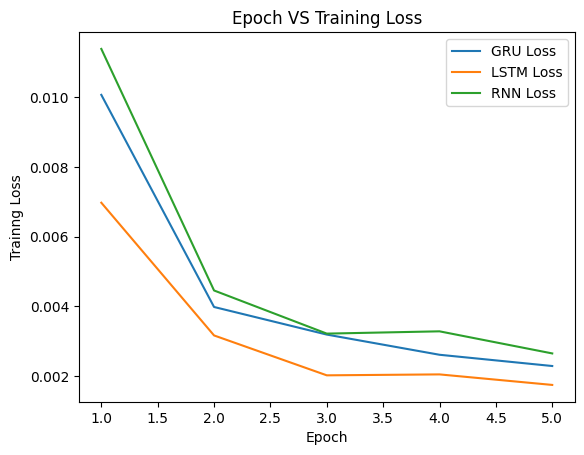

In [16]:
plt.figure()
plt.plot(np.arange(1, 6), gru_training_loss, label='GRU Loss')
plt.plot(np.arange(1, 6), lstm_training_loss, label="LSTM Loss")
plt.plot(np.arange(1, 6), rnn_training_loss, label="RNN Loss")
plt.title("Epoch VS Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Trainng Loss")
plt.legend()
plt.show()

In [17]:
y_RNN = regressor.predict(X_test)
y_LSTM = regressorLSTM.predict(X_test)
y_GRU = regressorGRU.predict(X_test)

y_RNN_O = scaler.inverse_transform(y_RNN)
y_LSTM_O = scaler.inverse_transform(y_LSTM)
y_GRU_O = scaler.inverse_transform(y_GRU)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 181ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step


1/4 ━━━━━━━━━━━━━━━━━━━━ 2s 777ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 287ms/step


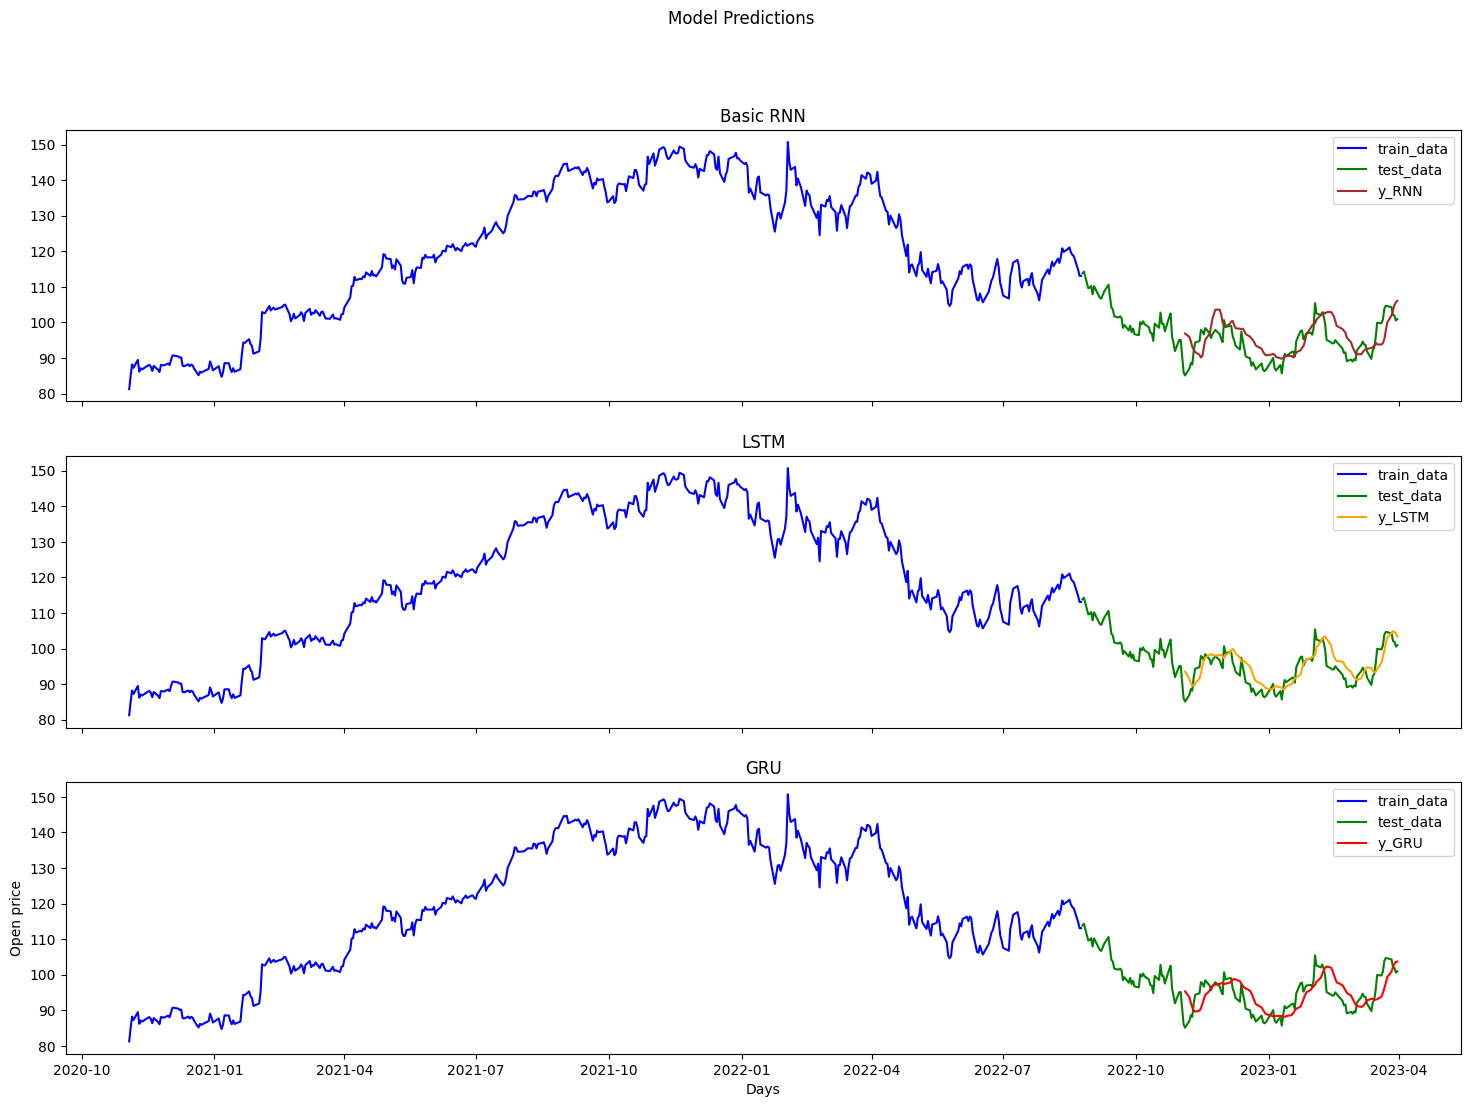

In [18]:
fig, axs = plt.subplots(3,figsize =(18,12),sharex=True, sharey=True)
fig.suptitle('Model Predictions')

# RNN Plotting
axs[0].plot(train_data.index[150:], train_data.Open[150:], label = "train_data", color = "b")
axs[0].plot(test_data.index, test_data.Open, label = "test_data", color = "g")
axs[0].plot(test_data.index[50:], y_RNN_O, label = "y_RNN", color = "brown")
axs[0].legend()
axs[0].title.set_text("Basic RNN")

# LSTM Plotting
axs[1].plot(train_data.index[150:], train_data.Open[150:], label = "train_data", color = "b")
axs[1].plot(test_data.index, test_data.Open, label = "test_data", color = "g")
axs[1].plot(test_data.index[50:], y_LSTM_O, label = "y_LSTM", color = "orange")
axs[1].legend()
axs[1].title.set_text("LSTM")

# GRU Plotting
axs[2].plot(train_data.index[150:], train_data.Open[150:], label = "train_data", color = "b")
axs[2].plot(test_data.index, test_data.Open, label = "test_data", color = "g")
axs[2].plot(test_data.index[50:], y_GRU_O, label = "y_GRU", color = "red")
axs[2].legend()
axs[2].title.set_text("GRU")

plt.xlabel("Days")
plt.ylabel("Open price")

plt.show()

What are the major differences you notice? Why do you think those differences exist between the 3 implementations (basic RNN, LSTM and GRU)?

LSTM has the lowest loss, followed by GRU, with RNN performing the worst. This is because:

RNN struggles with vanishing gradients, leading to poor long-term memory.
LSTM’s gating mechanism (input, forget, output gates) helps retain information better.
GRU is simpler than LSTM but still retains memory better than RNN, making it a middle ground.
LSTM excels at long-term dependencies, explaining its superior performance.

## Part 3
Can you use the traditional feed-forward network to solve the same
problem. Why or why not? (Hint: Can time series data be converted to usual features
that can be used as input to a feed-forward network?)

Answer: Yes, a traditional feed-forward network can be used for time series forecasting by transforming the sequential data into a supervised learning format. This is done by creating lagged features, where past stock prices serve as input features to predict future values. **However**, feed-forward networks do not inherently capture temporal dependencies since they treat each input independently. Unlike RNNs, which have memory through recurrent connections, feed-forward networks lack the ability to learn sequential patterns over time. As a result, while it is possible to use a feed-forward network for this problem, RNN-based models like LSTM and GRU are more effective because they are specifically designed to handle time-dependent relationships in data.

# Task 3

## Part 1

I chose Universal Sentence Encoder (USE) because it captures contextual meaning, provides fixed-size embeddings, and is optimized for semantic similarity, making it better than Word2Vec, GloVe, FastText, and more efficient than BERT.

In [19]:
import tensorflow_hub as hub
import numpy as np

module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
embeddings = hub.load(module_url)


## Part 2

Cosine similarity is useful in word embedding space because it measures the semantic closeness between words by calculating the angle between their vector representations, rather than their magnitude. This makes it scale-invariant, ensuring that words with similar meanings have higher similarity scores regardless of their vector lengths.

In [20]:
def calculate_similarity_cosine_distance(word1, word2):
    embed_x = embeddings([word1])[0].numpy()
    embed_y = embeddings([word2])[0].numpy()

    cosine_similarity = np.inner(embed_x, embed_y) / (np.linalg.norm(embed_x) * np.linalg.norm(embed_y))

    cosine_distance = 1 - cosine_similarity

    return cosine_similarity, cosine_distance

word1 = "good"
word2 = "bad"
cosine_similarity, cosine_distance = calculate_similarity_cosine_distance(word1, word2)
print(f'Cosine similarity between "{word1}" and "{word2}" is {cosine_similarity}.')
print(f'Cosine distance between "{word1}" and "{word2}" is {cosine_distance}.')


Cosine similarity between "good" and "bad" is 0.5944255590438843.
Cosine distance between "good" and "bad" is 0.4055744409561157.


In [21]:
def batch_similarity(word_pairs):
    results = {}
    for word1, word2 in word_pairs:
        cosine_similarity, cosine_distance = calculate_similarity_cosine_distance(word1, word2)
        results[(word1, word2)] = (cosine_similarity, cosine_distance)
    return results

# Example usage with multiple word pairs
word_pairs = [
    ("good", "bad"),
    ("cat", "dog"),
    ("happy", "joyful"),
    ("king", "queen")
]

similarities = batch_similarity(word_pairs)
for (word1, word2), (similarity, distance) in similarities.items():
    print(f'Cosine similarity between "{word1}" and "{word2}" is {similarity}.')
    print(f'Cosine distance between "{word1}" and "{word2}" is {distance}.')


Cosine similarity between "good" and "bad" is 0.5944255590438843.
Cosine distance between "good" and "bad" is 0.4055744409561157.
Cosine similarity between "cat" and "dog" is 0.6237586736679077.
Cosine distance between "cat" and "dog" is 0.3762413263320923.
Cosine similarity between "happy" and "joyful" is 0.749286413192749.
Cosine distance between "happy" and "joyful" is 0.250713586807251.
Cosine similarity between "king" and "queen" is 0.5885695219039917.
Cosine distance between "king" and "queen" is 0.4114304780960083.


In [22]:
word1 = "noun"
word2 = "joyful"
cosine_similarity, cosine_distance = calculate_similarity_cosine_distance(word1, word2)
print(f'Cosine similarity between "{word1}" and "{word2}" is {cosine_similarity}.')
print(f'Cosine distance between "{word1}" and "{word2}" is {cosine_distance}.')

Cosine similarity between "noun" and "joyful" is 0.2096862941980362.
Cosine distance between "noun" and "joyful" is 0.7903137058019638.


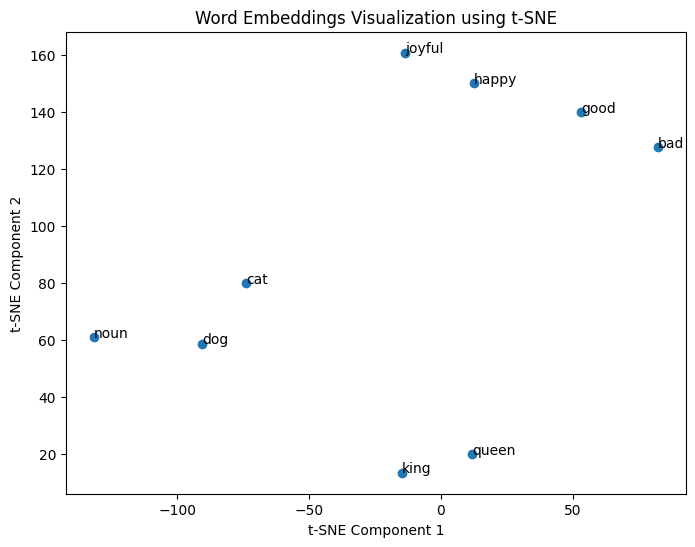

In [23]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

words = ["good", "bad", "cat", "dog", "happy", "joyful", "king", "queen", "noun"]
word_embeddings = embeddings(words)
word_embeddings = np.array(word_embeddings)

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42, perplexity=3) #Adjust perplexity as needed
word_embeddings_2d = tsne.fit_transform(word_embeddings)

# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(word_embeddings_2d[:, 0], word_embeddings_2d[:, 1])

# Add labels for each word
for i, word in enumerate(words):
    plt.annotate(word, (word_embeddings_2d[i, 0], word_embeddings_2d[i, 1]))

plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("Word Embeddings Visualization using t-SNE")
plt.show()


## Part 3

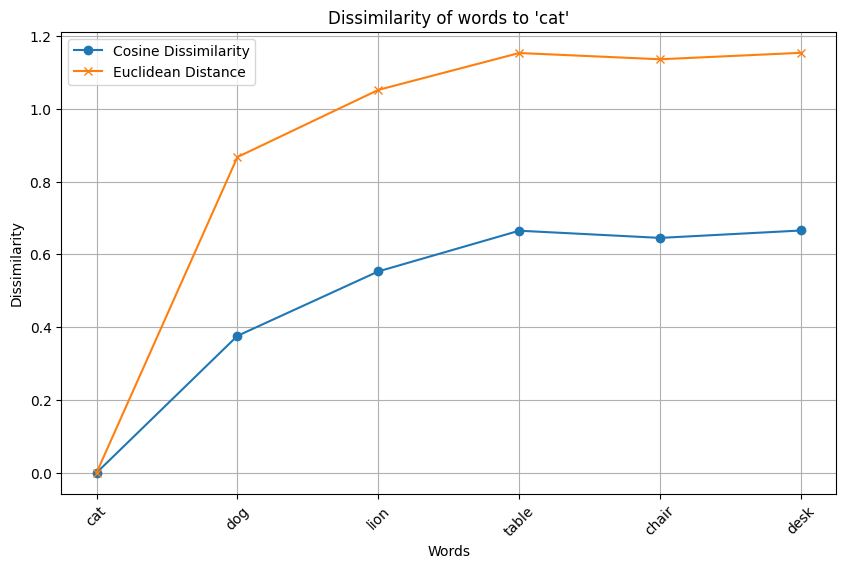

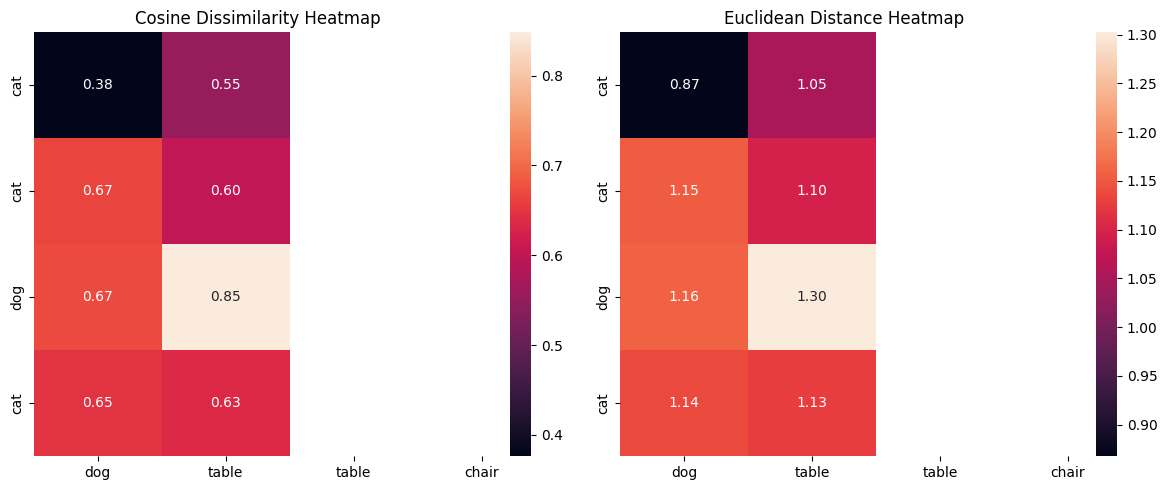

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def euclidean_distance(word1, word2):
    embed_x = embeddings([word1])[0].numpy()
    embed_y = embeddings([word2])[0].numpy()
    return np.linalg.norm(embed_x - embed_y)

def dissimilarity_metric(word1, word2, metric='cosine'):
    if metric == 'cosine':
        _, cosine_distance = calculate_similarity_cosine_distance(word1, word2)
        return cosine_distance
    elif metric == 'euclidean':
        return euclidean_distance(word1, word2)
    else:
        raise ValueError("Invalid dissimilarity metric")

# Example usage
words = ["cat", "dog", "lion", "table", "chair", "desk"]
reference_word = "cat"

# Calculate dissimilarities using different metrics
cosine_dissimilarities = [dissimilarity_metric(reference_word, word, metric='cosine') for word in words]
euclidean_dissimilarities = [dissimilarity_metric(reference_word, word, metric='euclidean') for word in words]


# Visualization: Ranking plot
plt.figure(figsize=(10, 6))
plt.plot(words, cosine_dissimilarities, label='Cosine Dissimilarity', marker='o')
plt.plot(words, euclidean_dissimilarities, label='Euclidean Distance', marker='x')
plt.xlabel("Words")
plt.ylabel("Dissimilarity")
plt.title(f"Dissimilarity of words to '{reference_word}'")
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

# Visualization: Heatmap
word_pairs = [
    ("cat", "dog"), ("cat", "lion"), ("cat", "table"),
    ("dog", "lion"), ("dog", "table"), ("lion", "table"),
    ("cat", "chair"), ("dog", "desk")
]

cosine_distances = []
euclidean_distances = []
for word1, word2 in word_pairs:
    cosine_distances.append(dissimilarity_metric(word1, word2, metric='cosine'))
    euclidean_distances.append(dissimilarity_metric(word1, word2, metric='euclidean'))

# Reshape for heatmap
cosine_matrix = np.array(cosine_distances).reshape(4,2)
euclidean_matrix = np.array(euclidean_distances).reshape(4,2)
word_pairs_matrix = np.array(word_pairs).reshape(4,4)

plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
sns.heatmap(cosine_matrix, annot=True, fmt=".2f", xticklabels=word_pairs_matrix[:,1], yticklabels=word_pairs_matrix[:,0])
plt.title("Cosine Dissimilarity Heatmap")

plt.subplot(1,2,2)
sns.heatmap(euclidean_matrix, annot=True, fmt=".2f", xticklabels=word_pairs_matrix[:,1], yticklabels=word_pairs_matrix[:,0])
plt.title("Euclidean Distance Heatmap")
plt.tight_layout()
plt.show()


Explain why your metric captures novelty/diversity better than cosine
similarity alone?

Euclidean distance considers the magnitude of the vectors, while cosine similarity only considers the angle between them.
In the context of word embeddings, words with similar meanings might have different vector lengths (magnitudes) depending on their frequency or other factors.
Cosine similarity is more robust to these differences in magnitude and focuses purely on the semantic orientation of the words.
Euclidean distance might incorrectly rank words that are semantically similar but have very different vector lengths.  
The choice depends on the application. If magnitude is important (e.g., frequency of words), then Euclidean distance might be better.
If the focus is on semantic similarity regardless of frequency or magnitude, cosine similarity is preferred.  For many NLP tasks, cosine similarity is the better choice.